This serves as an overview script of my workflow for data generated with a plate reader which hopefully enables me to partially automate that process.

But I also want to reuse code that I wrote and compensate for the lack of documentation in the python script (to keep me sane :D). 

*13.10.2022*

## Imports and general settings

In [1]:

# imports
import pandas as pd
import numpy as np # for calculating standard deviation and mean
import scipy.stats as sp # for calculating standard error
import matplotlib.pyplot as plt
import matplotlib
from pylatex import Figure, NoEscape, Subsubsection
from pylatex.utils import italic
import os
from sklearn import metrics
from scipy.optimize.minpack import curve_fit
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%run -i PARAMS.py
from PARAMS import *

pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)

Optional: We can define matplotlib to use pgf which makes importing into .tex better. Plots will not be shown but saved to a file. Defining the filepath only makes sense with that option.

In [183]:
#matplotlib.use("pgf")
#matplotlib.rcParams.update({"pgf.texsystem": "pdflatex", 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

## Utilities to preprocess the data

Data coming from the plate reade will have the time denoted in a funny format which we need to convert. We remove the funny format and return a dataframe with a usable time column.

In [2]:
def add_time(df):
    m = [isinstance(i, datetime) for i in df['Time']]
    df['timedelta'] = pd.to_timedelta(df['Time'].astype(str), errors='coerce')
    df.loc[m, 'timedelta'] = df.loc[m, 'Time'].apply(lambda t: pd.Timestamp(str(t)) - pd.Timestamp('1899-12-31'))
    df['Time'] = (df['timedelta'] - df['timedelta'][0])
    df['Time'] = df['Time'].dt.total_seconds() / 60
    df['Time'] += 15
    return df.drop('timedelta', axis=1)

We have a full dataframe where we want to average the technical replicates. It might be sensible to look at how the single columns look first in an overview plot and check whether one well might have done something weird and remove that. This is not possible with the following function.

`bio_rep` refers to a plate where we only looked at one strain with 3 biological replicates.

In [3]:
def extract_columns(df, conditions, bio_rep=False, bio_rep_name=''):
    """transforms excel table to df where the technical triplicates are averaged

    Args:
        df (pandas-df): excel from plate reader loaded
        conditions (dict): plate_layout loaded with convert_layout()
    """

    triplicates = df.iloc[:,2:].groupby(np.arange(len(df.iloc[:,2:].columns))//3, axis=1).mean()

    blank = triplicates[triplicates.columns[3::4]]
    blank.columns = np.arange(8)

    left = triplicates[triplicates.columns[::4]]
    left.columns = np.arange(8)
    left = left - blank
    left = left.rename(columns=conditions)
    left = df.iloc[:,:1].join(left, how='outer')
    left = add_time(left)

    middle = triplicates[triplicates.columns[1::4]]
    middle.columns = np.arange(8)
    middle = middle - blank
    middle = middle.rename(columns=conditions)
    middle = df.iloc[:,:1].join(middle, how='outer')
    middle = add_time(middle)

    right = triplicates[triplicates.columns[2::4]]
    right.columns = np.arange(8)
    right = right - blank
    right = right.rename(columns=conditions)
    right = df.iloc[:,:1].join(right, how='outer')
    right = add_time(right)
    
    def double_std(array):
        return np.std(array) * 2
    
    if bio_rep:
        df_concat = pd.concat((left, middle, right))
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        df_errors = by_row_index.agg([np.mean, double_std, sp.sem])
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right,
                   bio_rep_name: df_means}
    
    else:
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right}
        df_errors = None
    
    return  return_dict, df_errors

We define a csv where we denote the plate layout to save us some time later. This file is called `plate_layout.csv`. The following function will help us convert this csv to a dictionary which the holds all information on the plate layout.

In [8]:
def convert_layout(plate_layout_file = '../metadata/plate_layout.csv'):
    """converts csv layout file to work with other functions

    Args:
        plate_layout_file (str): Path to csv with layout. Defaults to 'plate_layout.csv'.

    Returns:
        dict: date as keys and layout as value (entry of the row)
    """
    layout = pd.read_csv(plate_layout_file)
    layout_dict = {}

    for entry in layout.to_dict('records'):
        new_dict = {}
        for k, v in entry.items():
            try: 
                k = int(k)
                new_dict[k] = v
            except(ValueError):
                new_dict[k] = v
        layout_dict[new_dict['date']] = new_dict
    
    return layout_dict

If you use the naming schema yymmdd<some more info>.xlsx the following function can be used aswell. 

In [12]:
def get_info(excel_file):
    date = excel_file[:10]
    nice_date = date[8:] + '.' + date[5:7] + '.' + date[:4]
    plate_layout = convert_layout()[date]
    nrows = 0 
    if plate_layout['duration'] == 24.0:
        nrows = 96 #96 for 24
    if plate_layout['duration'] == 48.0:
        nrows = 193 #193 for 48h
    bio_rep_name = ''
    if plate_layout['biological replicates']:
        bio_rep_name = str(int(plate_layout['strain']))
    return nrows, plate_layout, bio_rep_name, nice_date

## Focus: One strain in multiple media

### Averaging technical replicates and plotting

This way we will only need to give the path to the folder where we store the excel files coming from the plate reader (`path_to_excel`) and the excel file of interest (`excel_file`).

In [74]:
# inputs
path_to_excel = '../data/raw/'

###
# you only need to modify this and denote layout in plate_layout.csv
excel_file = '2022-06-15_16.xlsx' 
STRAIN = excel_file[11:13]

Now we are all set to plot the first dataset. If we look at biological replicates, they will be numbered. The plot titled only with the strain shows the averaged curves.

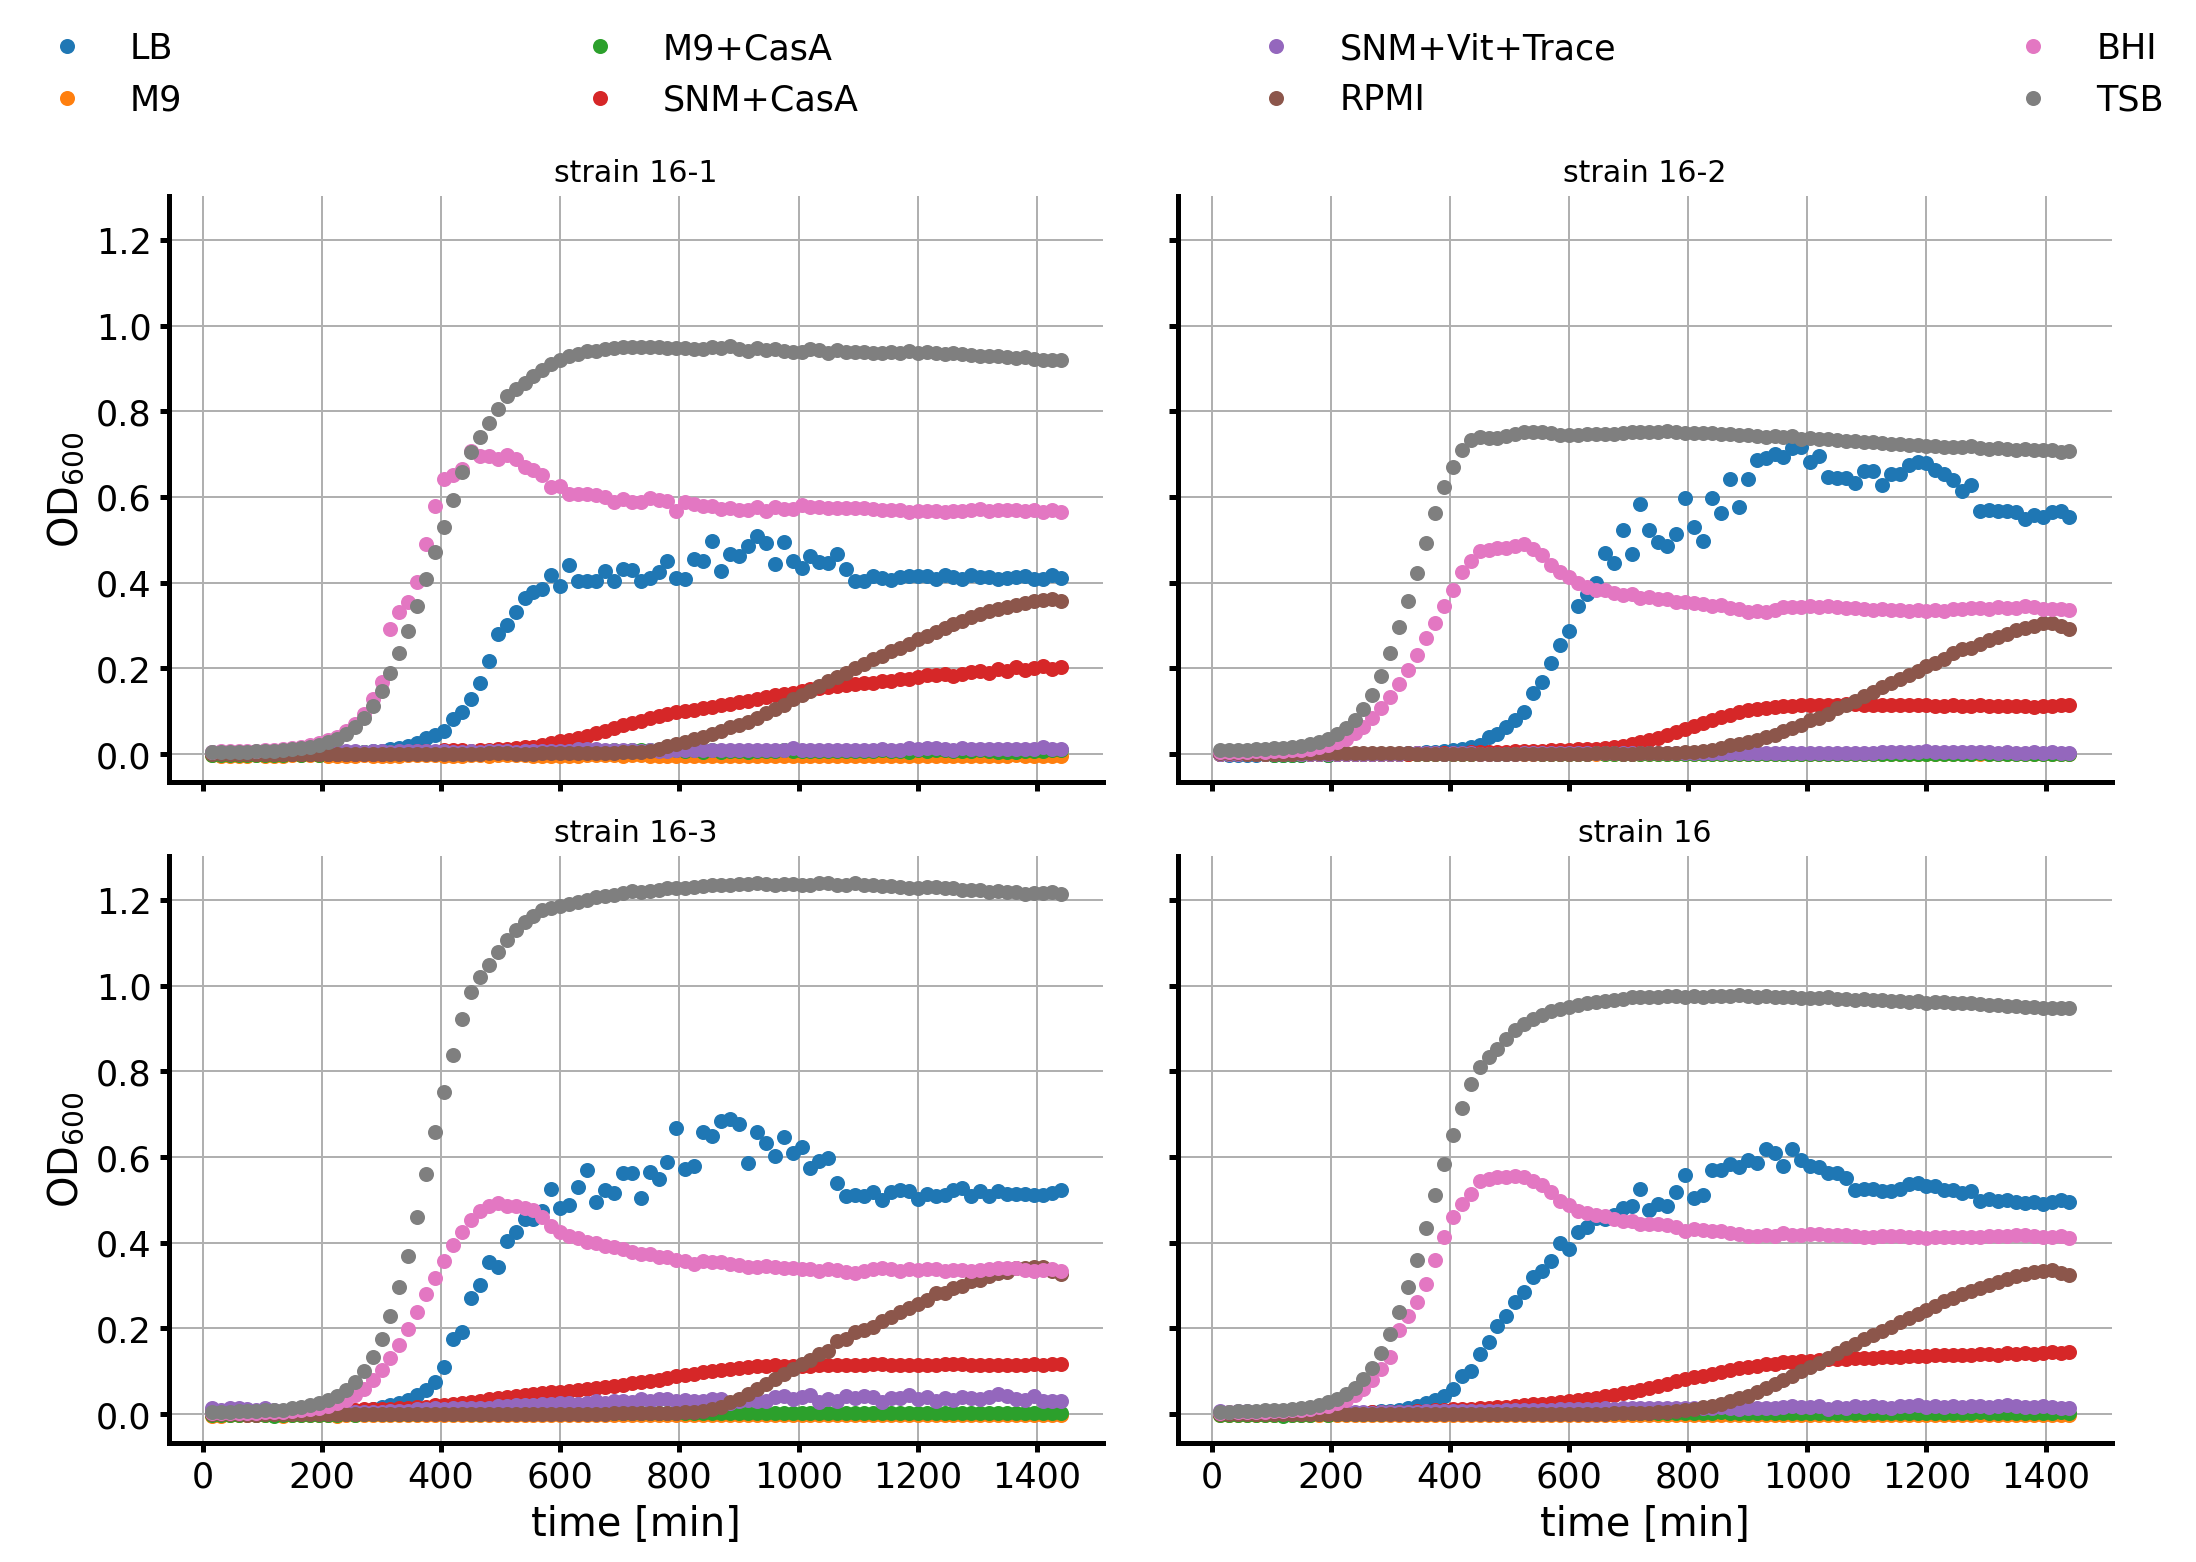

In [75]:
nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
df = pd.read_excel(path_to_excel+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
growth, errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)

plot_number = 0
fig, axs = plt.subplots(2,2, figsize=(12, 8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
for strain, dataframe in growth.items():
        dataframe.plot(grid=True, 
                x="Time",
                style = '.',
                xlabel='time [min]',
                ylabel='OD$_{600}$',
                title='strain ' + strain,
                ax=axs[plot_number],
                legend=False,
                ms=10,
                )
        handles, labels = axs[plot_number].get_legend_handles_labels()
        plot_number += 1

plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(0., 1, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)

I noticed that most microbiology papers and posters use black and white figures and thicker axes. Below is an example on how to style a plot that way.

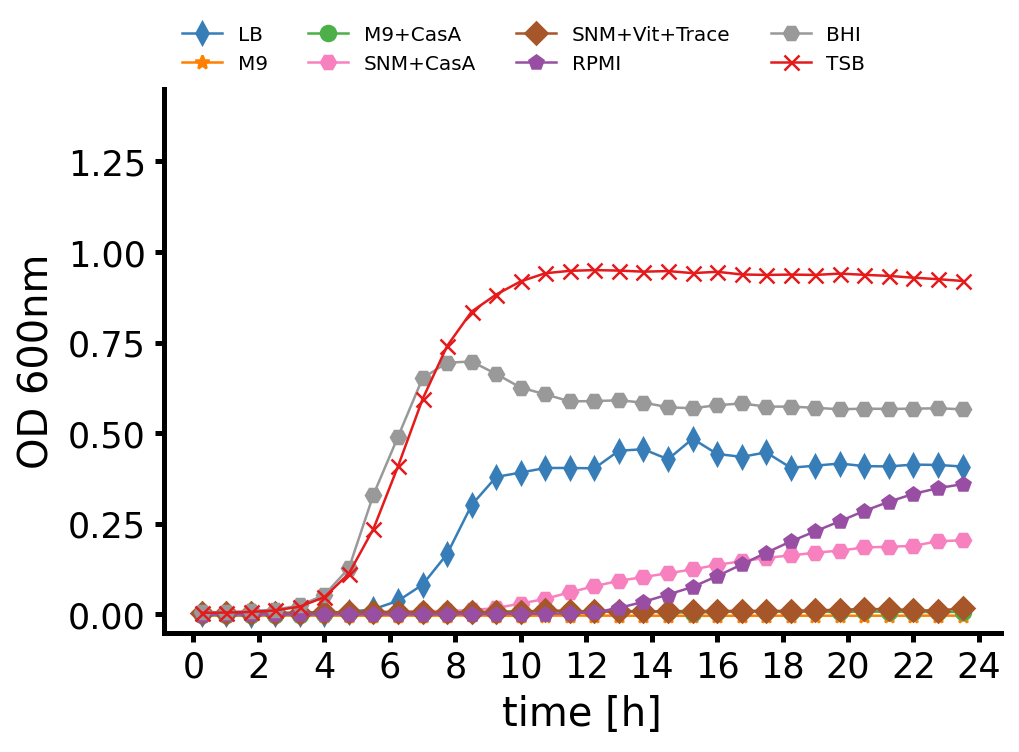

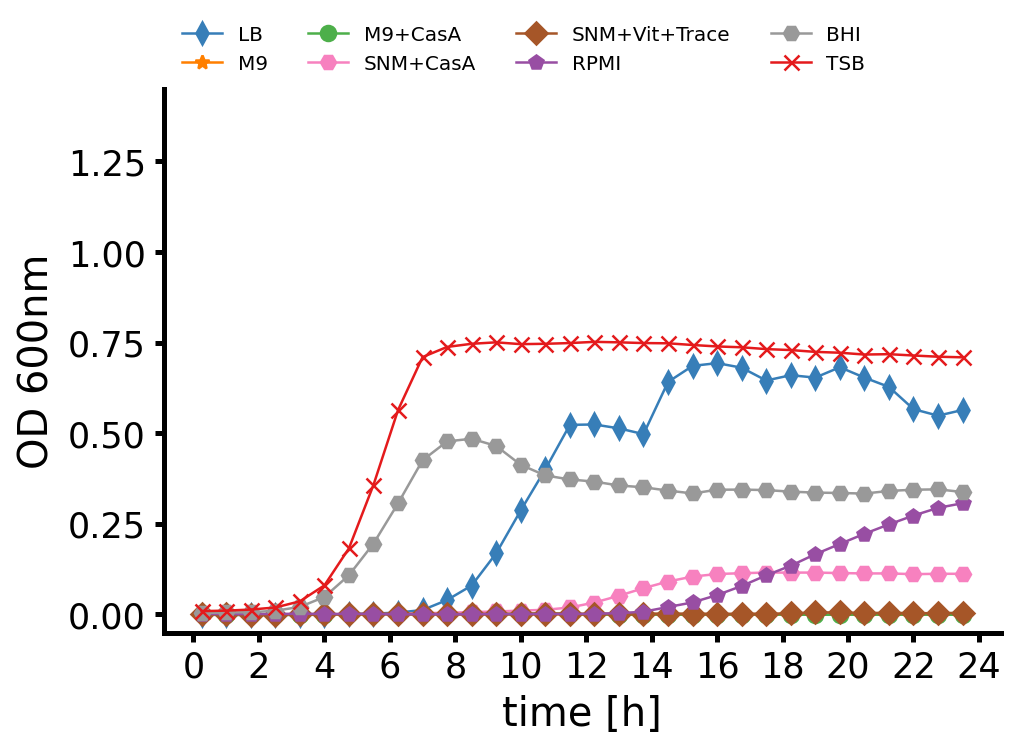

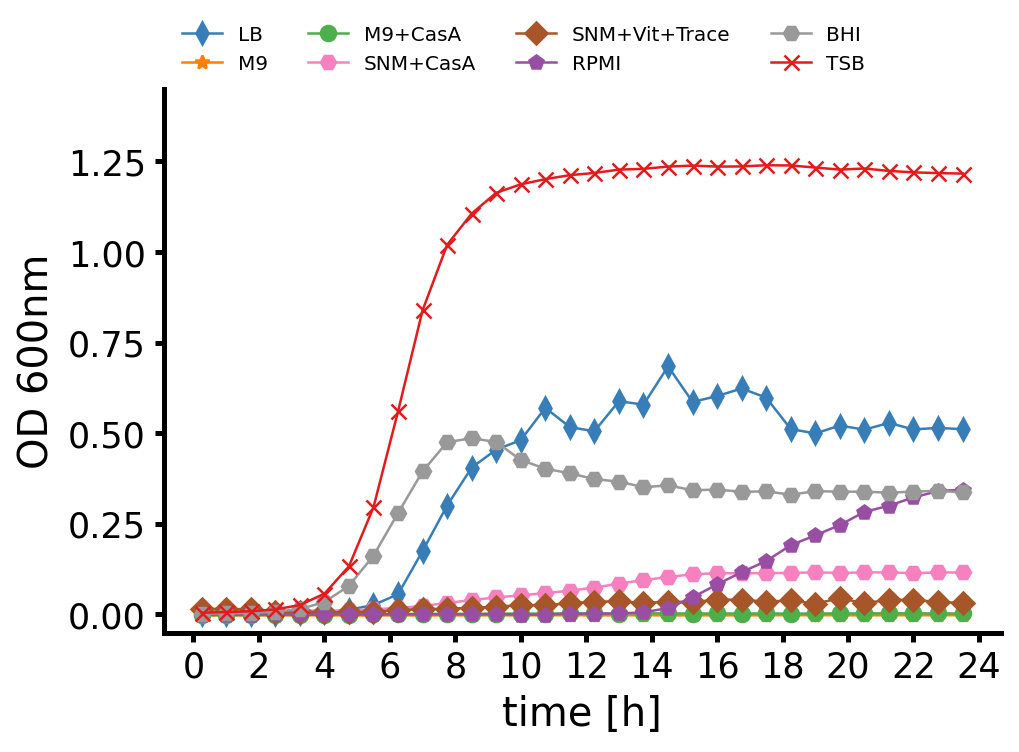

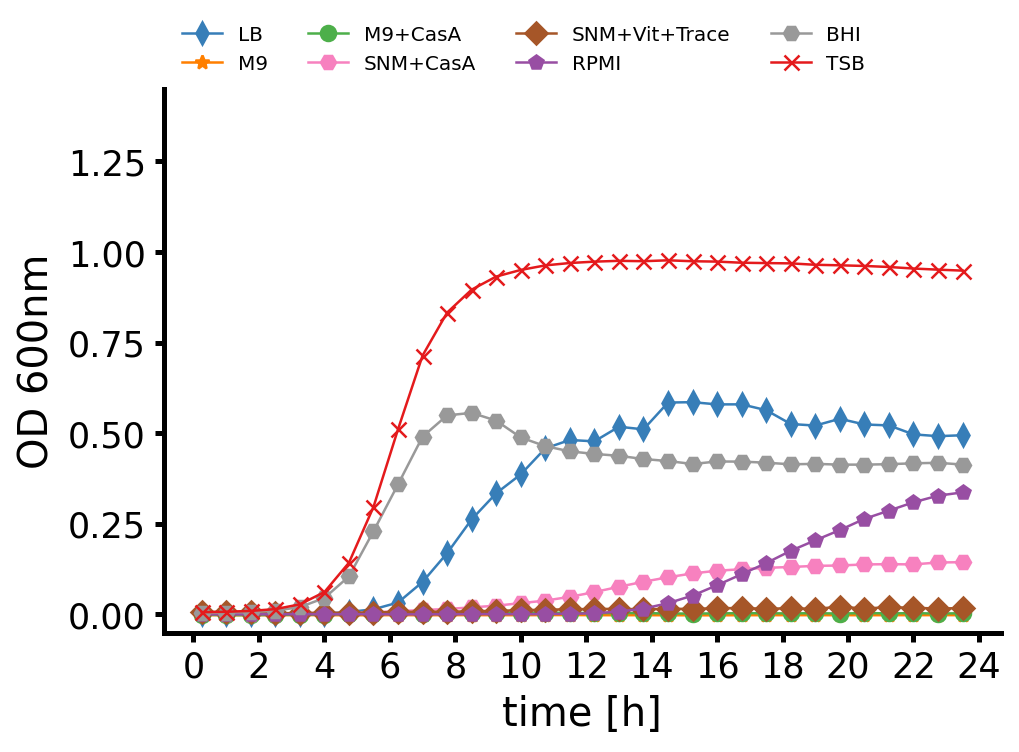

<Figure size 1080x720 with 0 Axes>

In [55]:
nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
df = pd.read_excel(path_to_excel+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
growth, errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)

for strain, dataframe in growth.items():
        i = 0
        ax = plt.figure()
        for col in dataframe.drop(['Time'], axis=1).columns:
                plt.plot(dataframe['Time'][::3] / 60, dataframe[col][::3], marker=markers[i], color=cb[i], label=col, linewidth=1.0)
                i+=1
        #plt.xticks(np.arange(0, errors['Time']['mean'].max() / 60, 4))
        plt.xlabel('time [h]', fontsize=16)
        plt.ylabel('OD 600nm', fontsize=16)
        plt.ylim(-0.05,1.45)
        plt.xticks(np.arange(0,24.5, 2))
        plt.legend(bbox_to_anchor=(0, 1.15), loc='upper left', ncol=4, fontsize=8, frameon=False)#, mode="expand", borderaxespad=0., fontsize=12)
        plt.show()

plt.tight_layout()
#fig.legend(handles, labels, bbox_to_anchor=(0., 1, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)

### Fitting the growth curves to extract the growth rate

We need to define the function that we will use to fit our data using curve_fit.

In [373]:
def logistic_mod(t, K, N0, r): #asadi2020
    return K/(1+((K-N0)/N0)*np.exp(-r*t))

def gompertz(t,K,lag,r): #based on Franses94 and Korkmaz2020
    return K*np.exp(-lag*np.exp(-r*t))

We can build a function which will fit all curves denoted in our dataframe.

In [374]:
def extract_growthrate(df, fit_func, rename=['a', 'b', 'growth rate'], p0=np.asarray([0.2,0.005,0.05])):

    df_growth = pd.DataFrame()
    aucs = []
    popts = {}
    pcovs = {}
    for (columnName, columnData) in df.drop('Time', axis=1).iteritems():
        auc = metrics.auc(df['Time'], columnData.values)
        aucs.append(auc)
        try:
            popts[columnName], pcovs[columnName] = curve_fit(fit_func, df['Time'], df[columnName], p0)#, bounds=[[0,-1.0,-1.0],[1.0,1.0,1.0]])
        except (RuntimeError):
            print('RuntimeError for ' + columnName + ' set popts to 1')
            a=np.empty(len(p0))
            a.fill(1)
            popts[columnName] = a
    
    fit_parameters = pd.DataFrame.from_dict(popts,
                                                orient='index',
                                                columns=rename)
    df_growth['growth rate'] = fit_parameters['growth rate']
    try:
        df_growth['doubling time'] = np.log(2)/fit_parameters['growth rate']
    except (ZeroDivisionError):
        print('No doubling time could be calculated for ' + columnName)
        df_growth['doubling time'] = 0
    df_growth['AUC'] = aucs
    
    return df_growth, fit_parameters

We can define a plot function which will show the fits and the original data.

In [375]:
def plot_fitted_curves(df, fit_func, fit_parameters, title, df_display):
    fig = plt.figure(figsize=(30,10)) #30,10
    ax1 = fig.add_subplot(121)
    
    t = np.linspace(df['Time'].min(), df['Time'].max())#, 193)

    ax = df.plot(grid=True, 
                    x="Time",
                    style = '.',
                    xlabel='time [min]',
                    ylabel='OD$_{600}$',
                    ax=ax1,
                    markersize=15
                    )

    for idx, column in enumerate(df.set_index('Time').columns):
        try:
            plt.plot(t,fit_func(t, *fit_parameters.loc[column]),
                color='C{}'.format(idx))
        except (ZeroDivisionError):
            pass
    plt.title(title)
    
    ax2 = fig.add_subplot(122)
    font_size = 20
    bbox = [0, 0, 1, 1]
    ax2.axis('off') 
    ax2.table(cellText=df_display.round(2).values, rowLabels=df_display.index, 
              bbox=bbox, 
              colLabels=df_display.columns,
              )
    plt.tight_layout() 
    return fig

Using the functions defined above we can now fit the data and plot the results of the fit as well as display the extracted growth characteristics as a table.

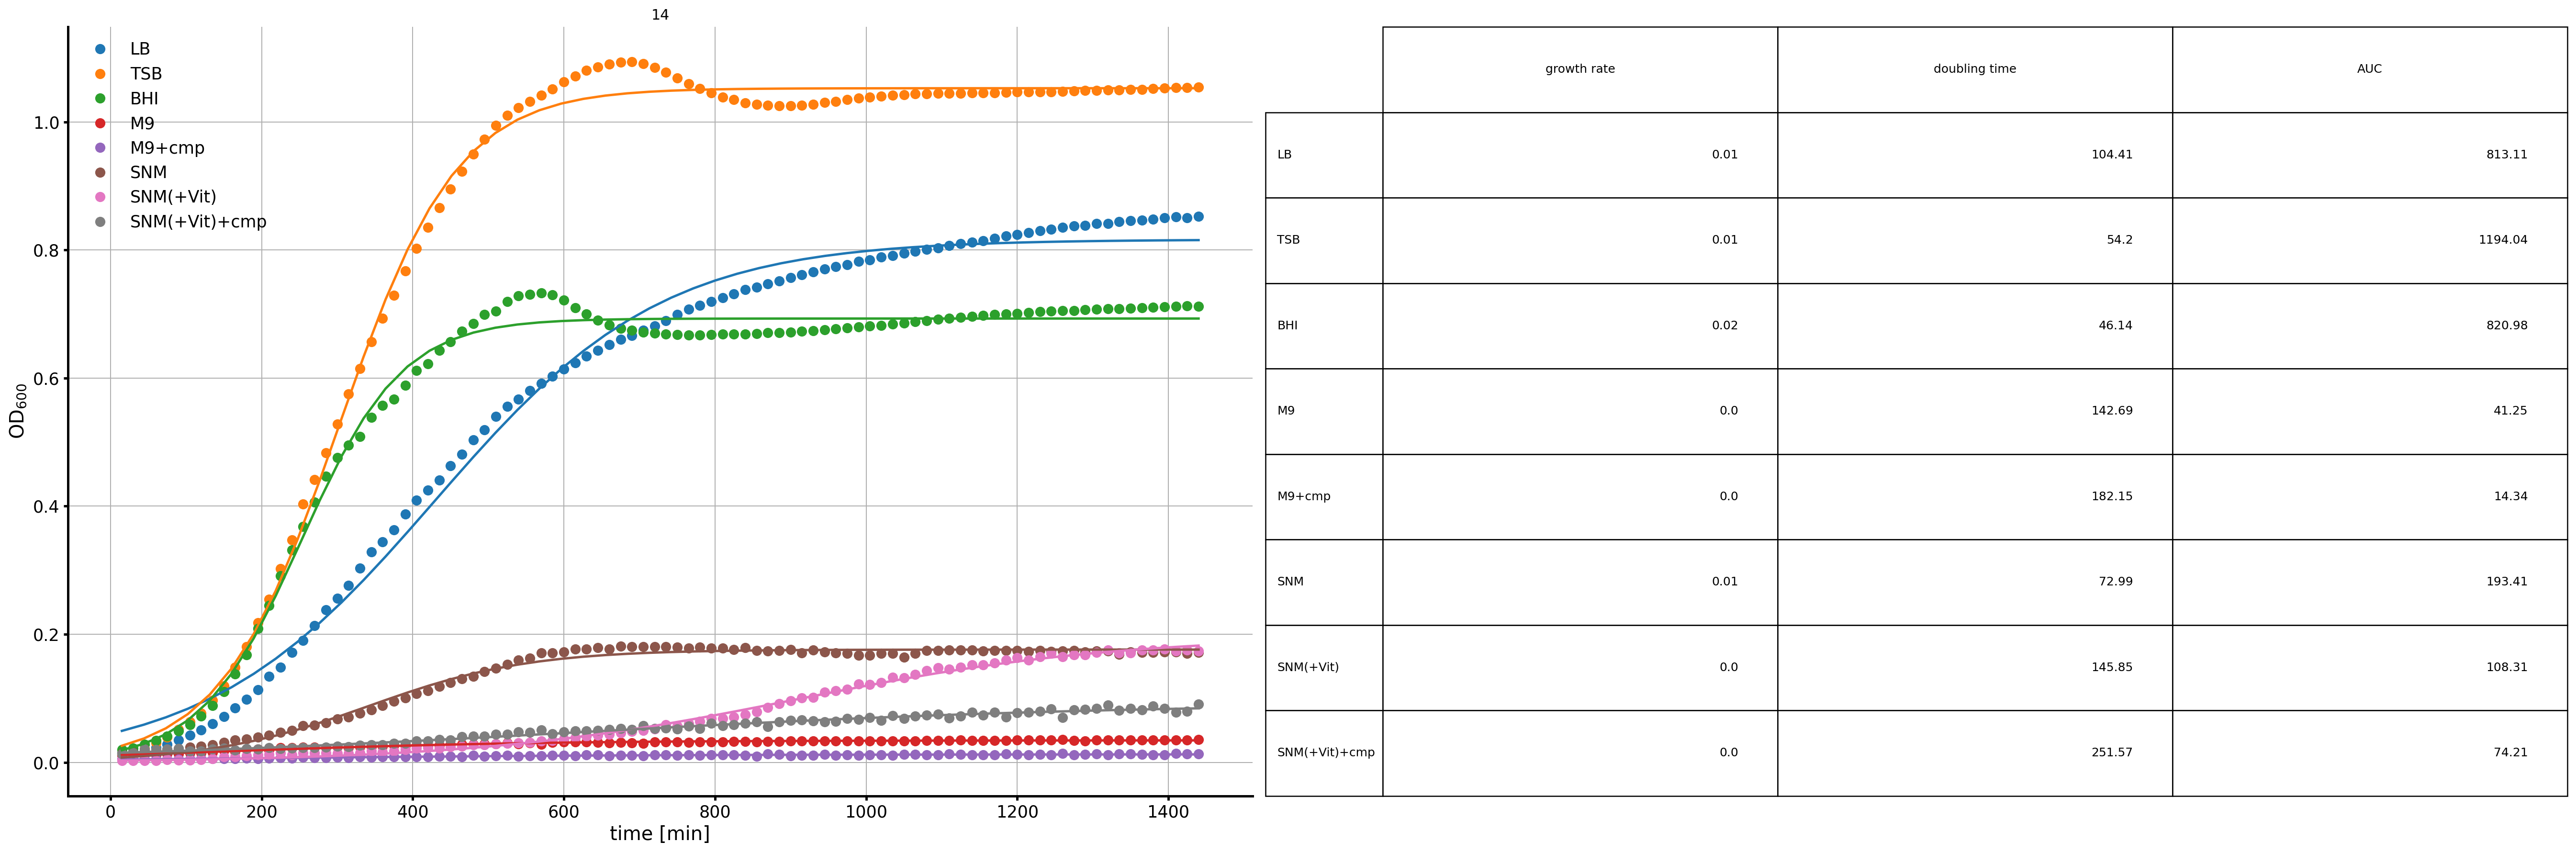

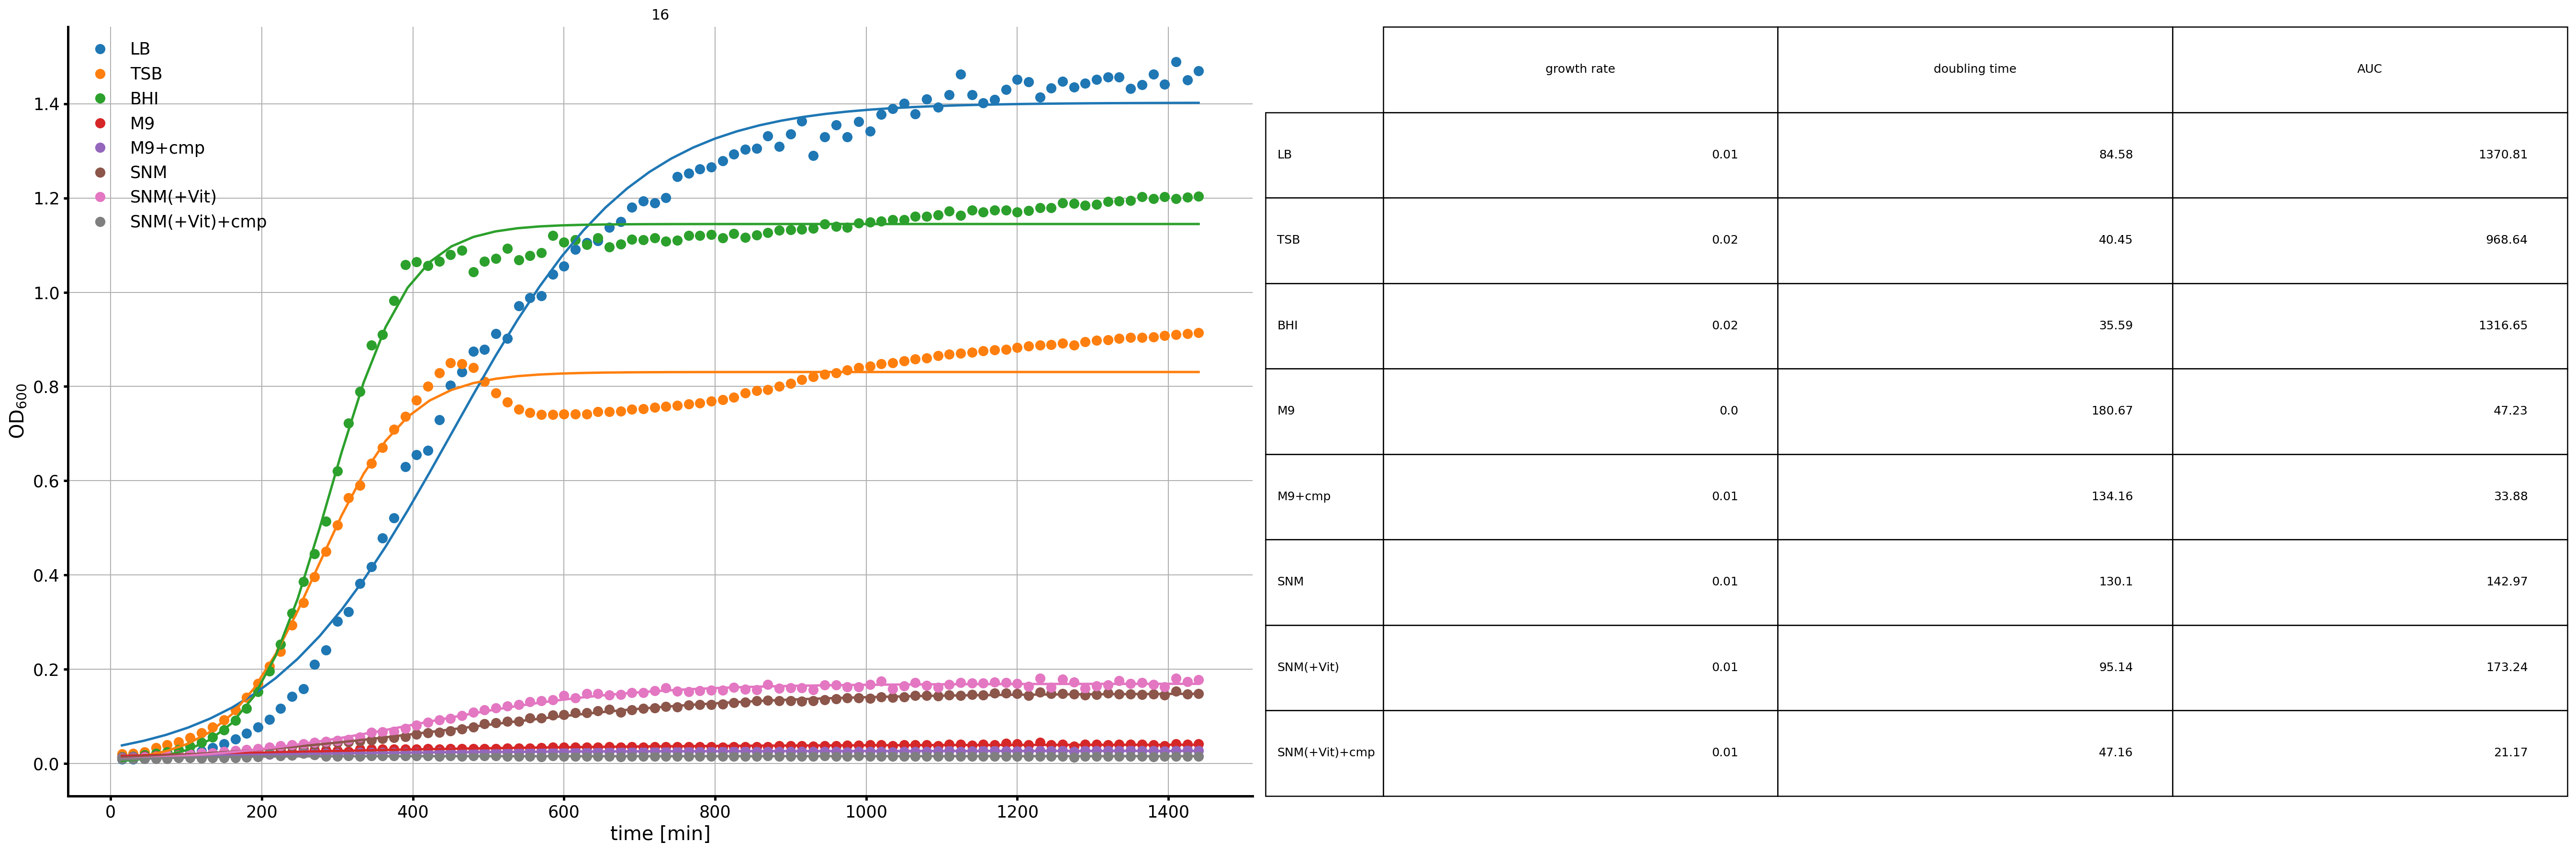

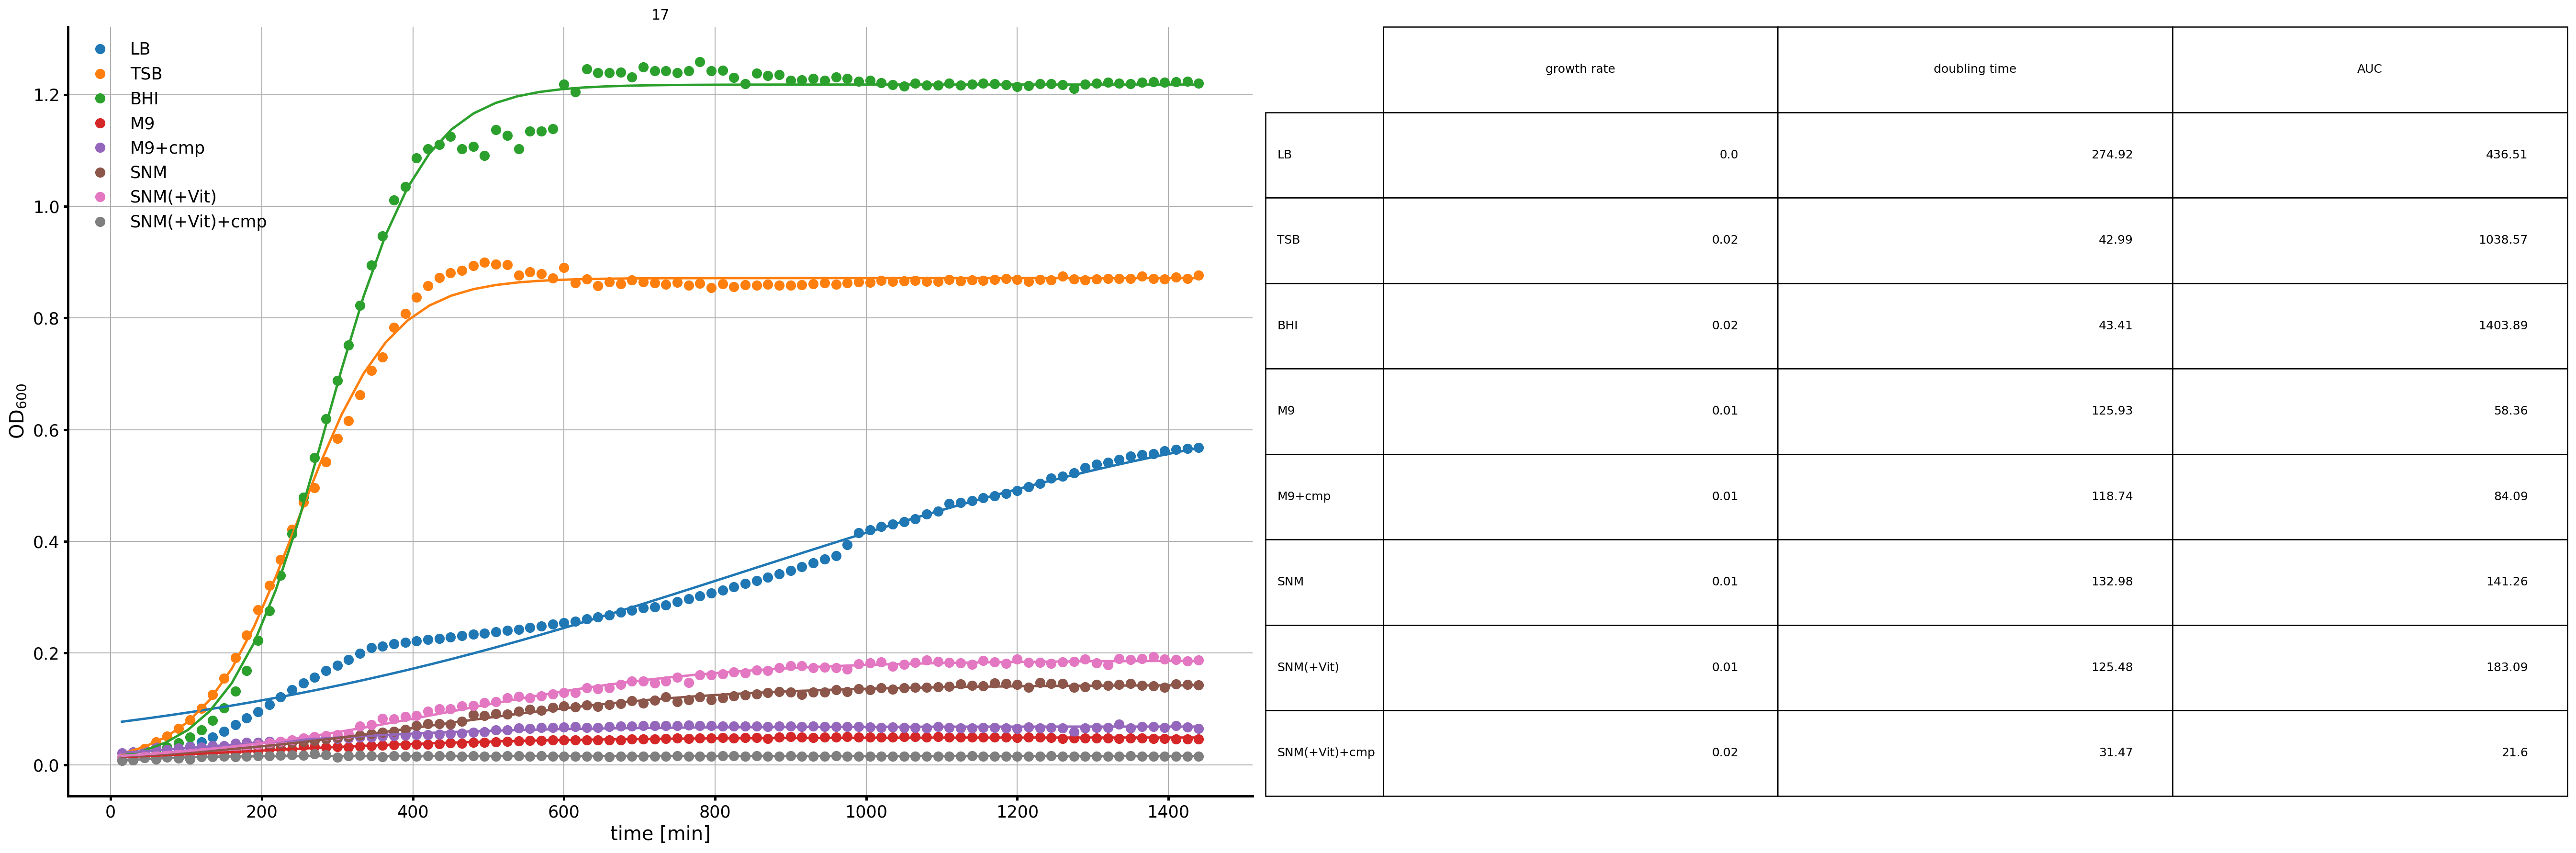

In [376]:
plt.close('all')
fit_func = logistic_mod
for strain, dataframe in growth.items():
    df_growth, fit_params = extract_growthrate(dataframe, fit_func)
    plot_fitted_curves(dataframe, fit_func, fit_params, strain, df_growth)

### Plotting biological replicates with errorbars

This only works with results from plates with biological replicates of the same strain. For other plates `errors` will be empty.

From averaging the biological replicates we also return a dataframe containing those errors (see `extract_columns`). This returns the mean, the standard deviation and the standard error and looks as shown below.

In [24]:
errors[['Time', 'LB']].head()

Time                        LB                     
   mean double_std  sem      mean double_std       sem
0  15.0        0.0  0.0  0.009222   0.002200  0.000778
1  30.0        0.0  0.0  0.009000   0.002177  0.000770
2  45.0        0.0  0.0  0.008889   0.002455  0.000868
3  60.0        0.0  0.0  0.009667   0.002494  0.000882
4  75.0        0.0  0.0  0.010222   0.002740  0.000969

We can plot those errors using the `plt.errorbar` function.

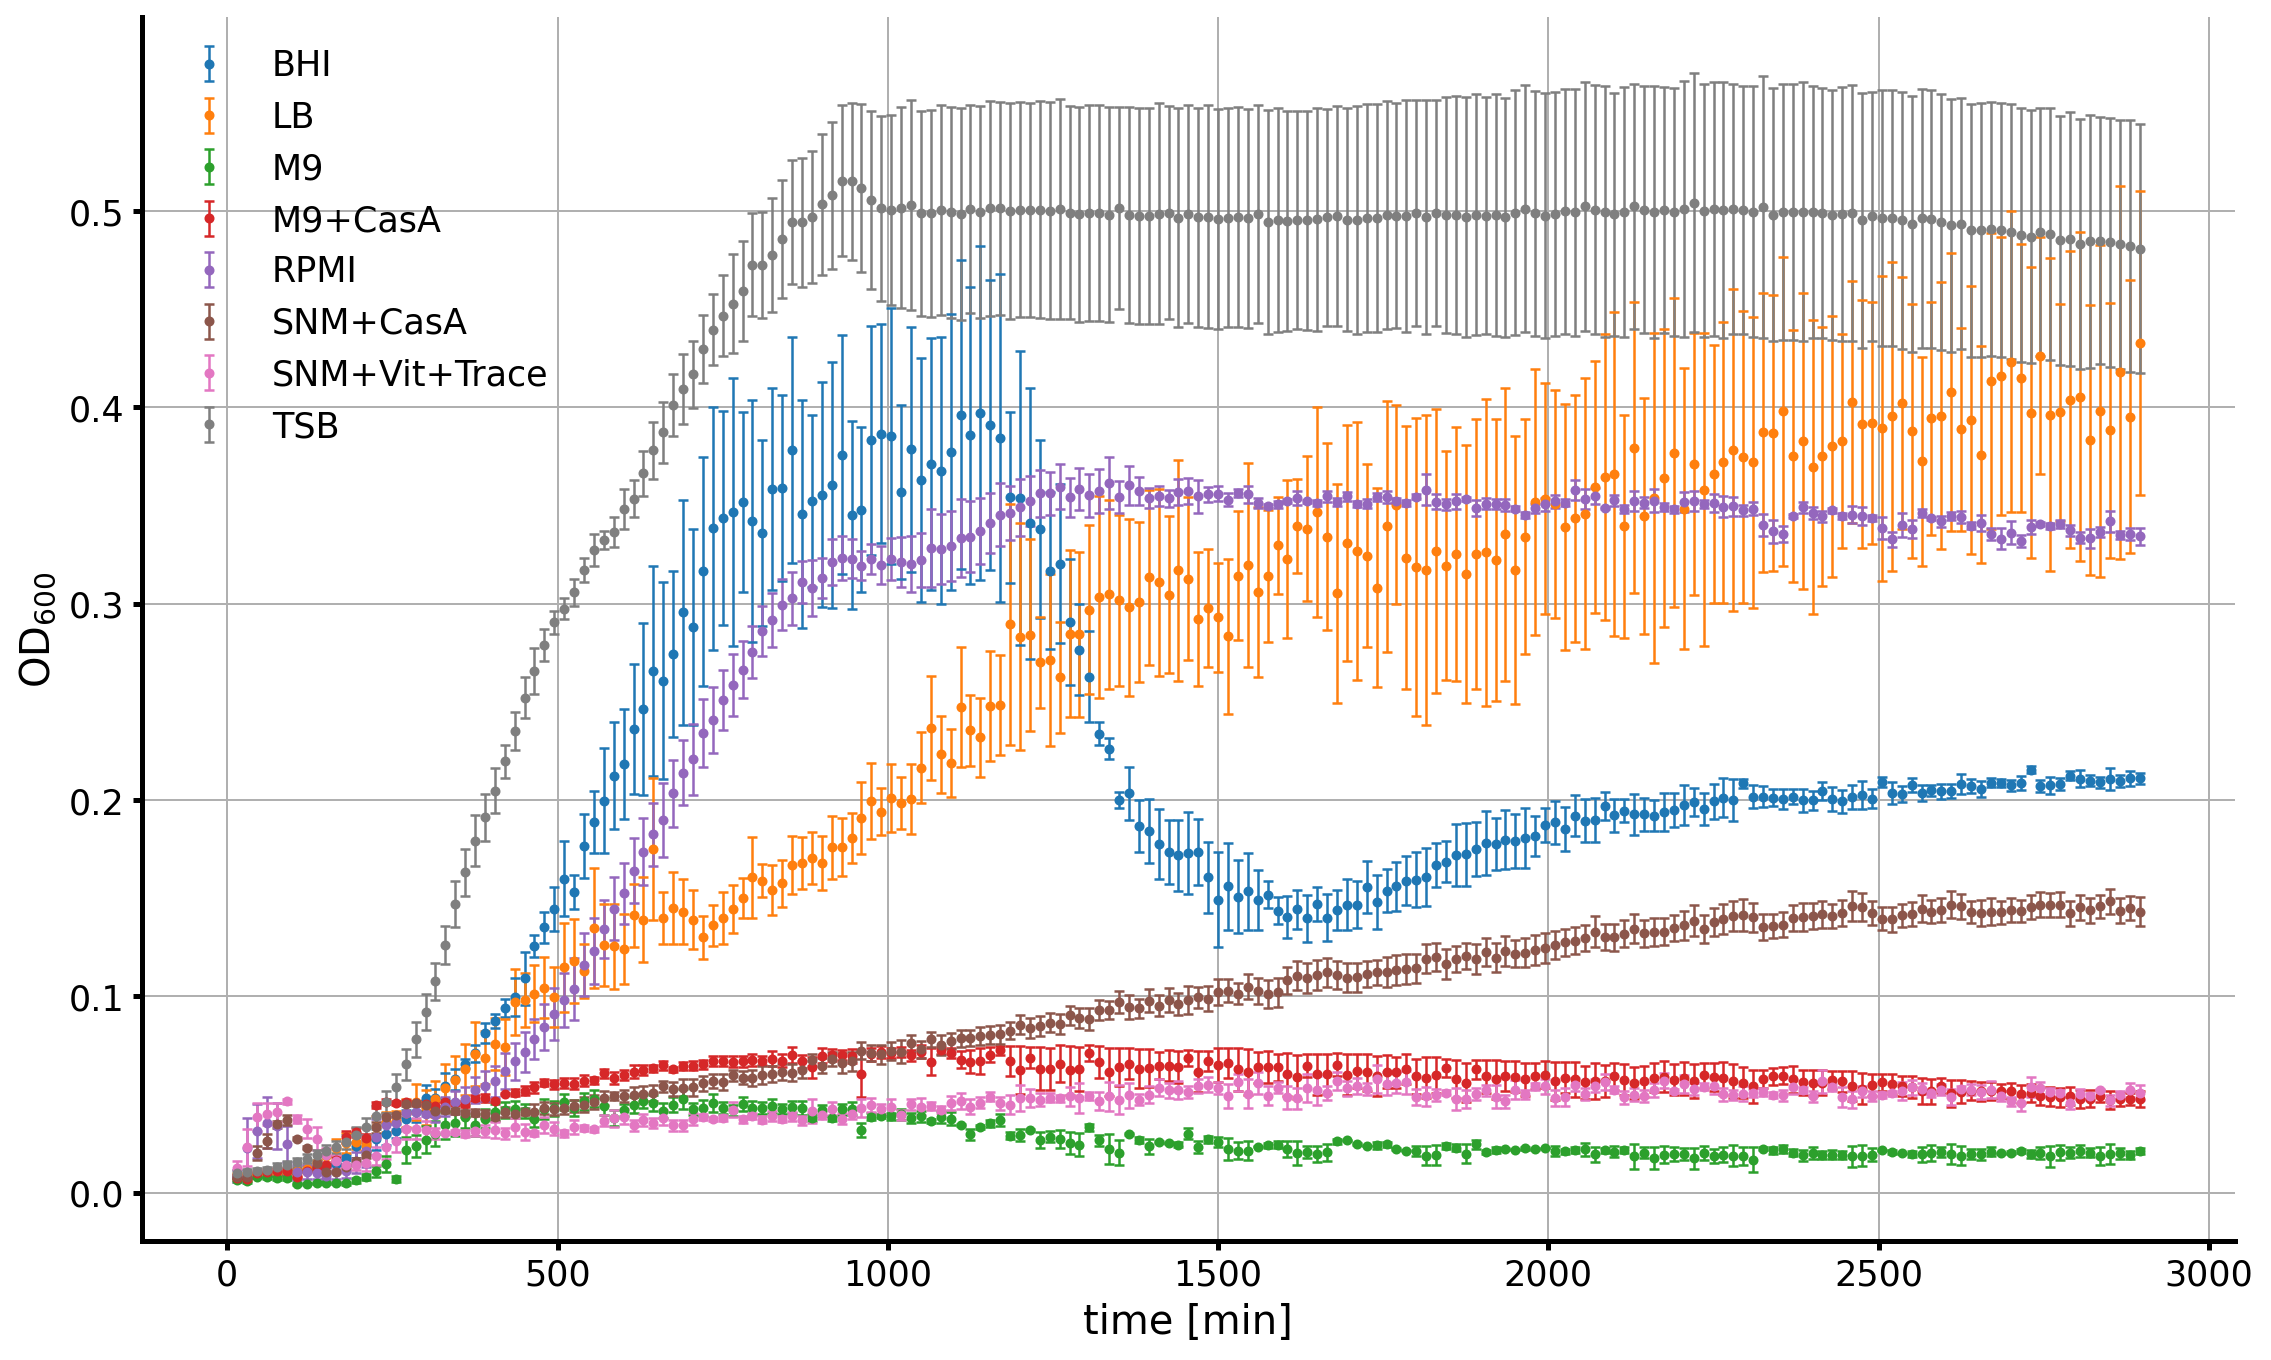

In [25]:
plt.close('all')
fig = plt.figure(figsize=(15, 9))
for medium, values in errors.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        plt.errorbar(x = errors['Time']['mean'],
                    y = values[medium]['mean'],
                    yerr = values[medium]['sem'],
                    capsize=2, 
                    elinewidth=1,
                    fmt='.',
                    label=medium,
                    markeredgewidth=1,
                    )
        #plt.yscale('log', nonpositive='clip')
        plt.xlabel('time [min]')
        plt.ylabel('OD$_{600}$')
        plt.grid(True)
        plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

Below you can also find a styled plot but with errorbars.

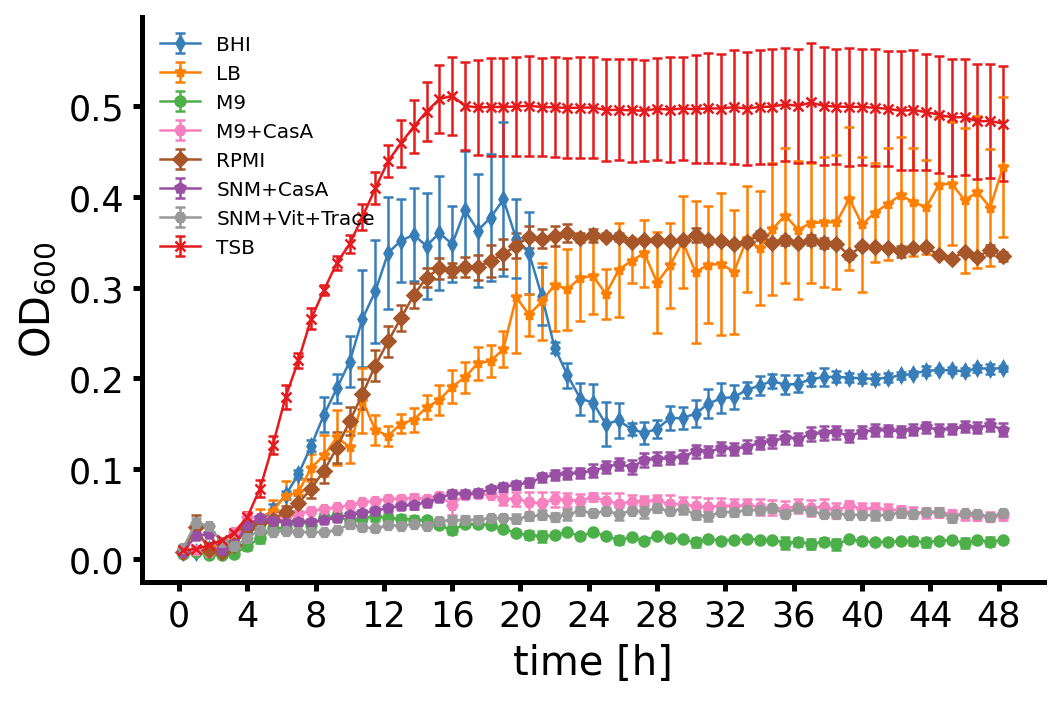

In [26]:
plt.close('all')
i = 0
for medium, values in errors.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        plt.errorbar(x = errors['Time']['mean'][::3] / 60,
                y = values[medium]['mean'][::3],
                yerr = values[medium]['sem'][::3],
                fmt='.',
                label=medium,
                marker=markers[i],
                color = cb[i],
                ms=4,
                linestyle='-',
                linewidth=1.0,
                )
        plt.xticks(np.arange(0, errors['Time']['mean'].max() / 60, 4))
        plt.xlabel('time [h]')
        plt.ylabel('OD$_{600}$')
        plt.legend(fontsize=8,)# bbox_to_anchor=(-0.00, 1.15), loc='upper left', ncol=4)
        i +=1

plt.tight_layout()

Now we only want the tested complex media to appear in the styled plot.

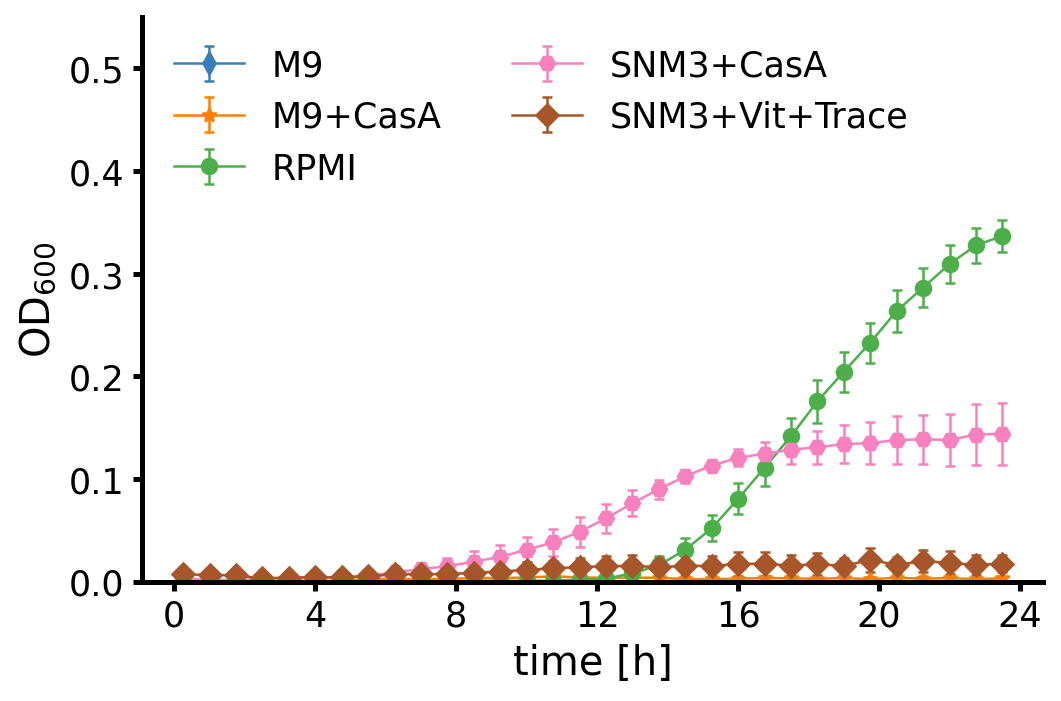

In [76]:
plt.close('all')
i = 0
interest = errors.drop(['BHI', 'TSB', 'LB'], axis=1)
# auc einfügen!!!
interest.rename({'SNM+CasA':'SNM3+CasA', 'SNM+Vit+Trace':'SNM3+Vit+Trace'}, axis=1, inplace=True)
for medium, values in interest.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        plt.errorbar(x = errors['Time']['mean'][::3] / 60,
                y = values[medium]['mean'][::3],
                yerr = values[medium]['sem'][::3],
                fmt='.',
                label=medium,
                marker=markers[i],
                color = cb[i],
                ms=6,
                linestyle='-',
                linewidth=1.0,
                )
        plt.xticks(np.arange(0, errors['Time']['mean'].max() / 60 + 1, 4))
        plt.xlabel('time [h]')
        plt.ylabel('OD$_{600}$')
        plt.ylim((0,0.55))
        plt.legend(loc='upper left', ncol=2)#fontsize=8,)# bbox_to_anchor=(-0.00, 1.15), loc='upper left', ncol=4)
        i +=1

plt.tight_layout()
plt.savefig('../figures/defined_media/' + excel_file[:10] + '_Cstr_' + str(STRAIN) + '.png')

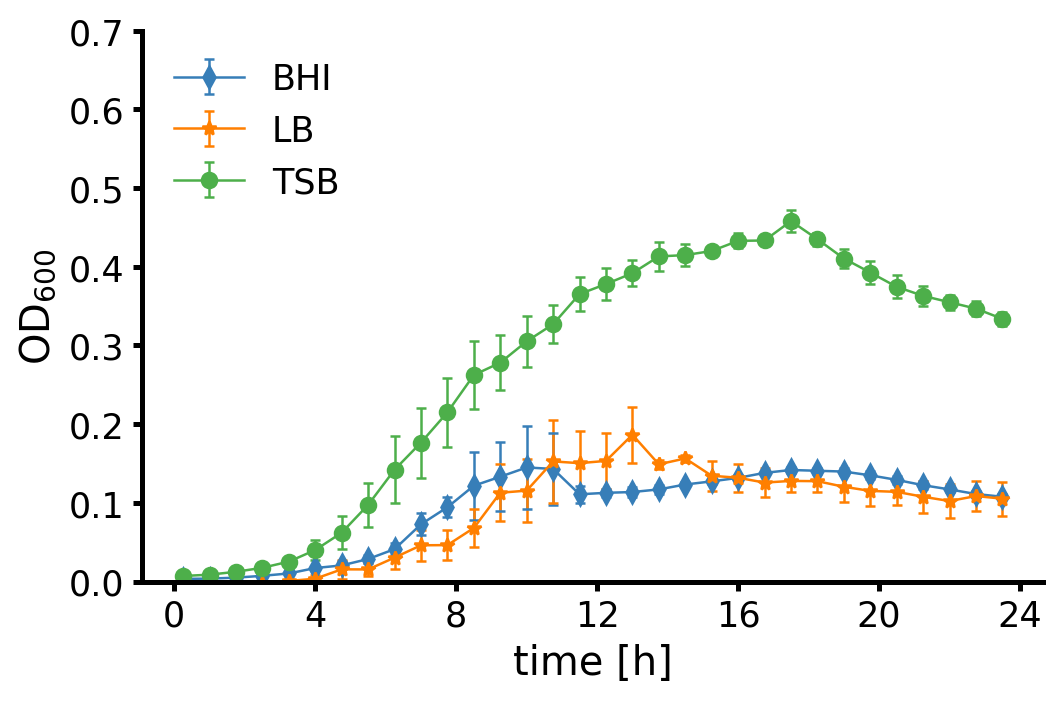

In [59]:
plt.close('all')
i = 0
interest = errors.drop(['M9', 'M9+CasA', 'RPMI', 'SNM+CasA', 'SNM+Vit+Trace'], axis=1)
# auc einfügen!!!
for medium, values in interest.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        plt.errorbar(x = errors['Time']['mean'][::3] / 60,
                y = values[medium]['mean'][::3],
                yerr = values[medium]['sem'][::3],
                fmt='.',
                label=medium,
                marker=markers[i],
                color = cb[i],
                ms=6,
                linestyle='-',
                linewidth=1.0,
                )
        plt.xticks(np.arange(0, errors['Time']['mean'].max() / 60 + 1, 4))
        plt.xlabel('time [h]')
        plt.ylabel('OD$_{600}$')
        plt.ylim((0,0.7))
        plt.legend(loc='upper left')#fontsize=8,)# bbox_to_anchor=(-0.00, 1.15), loc='upper left', ncol=4)
        i +=1

plt.tight_layout()
plt.savefig('../figures/complex_media/' + excel_file[:10] + '_Cstr_' + str(STRAIN) + '.png')

One step further is to also display the fit.

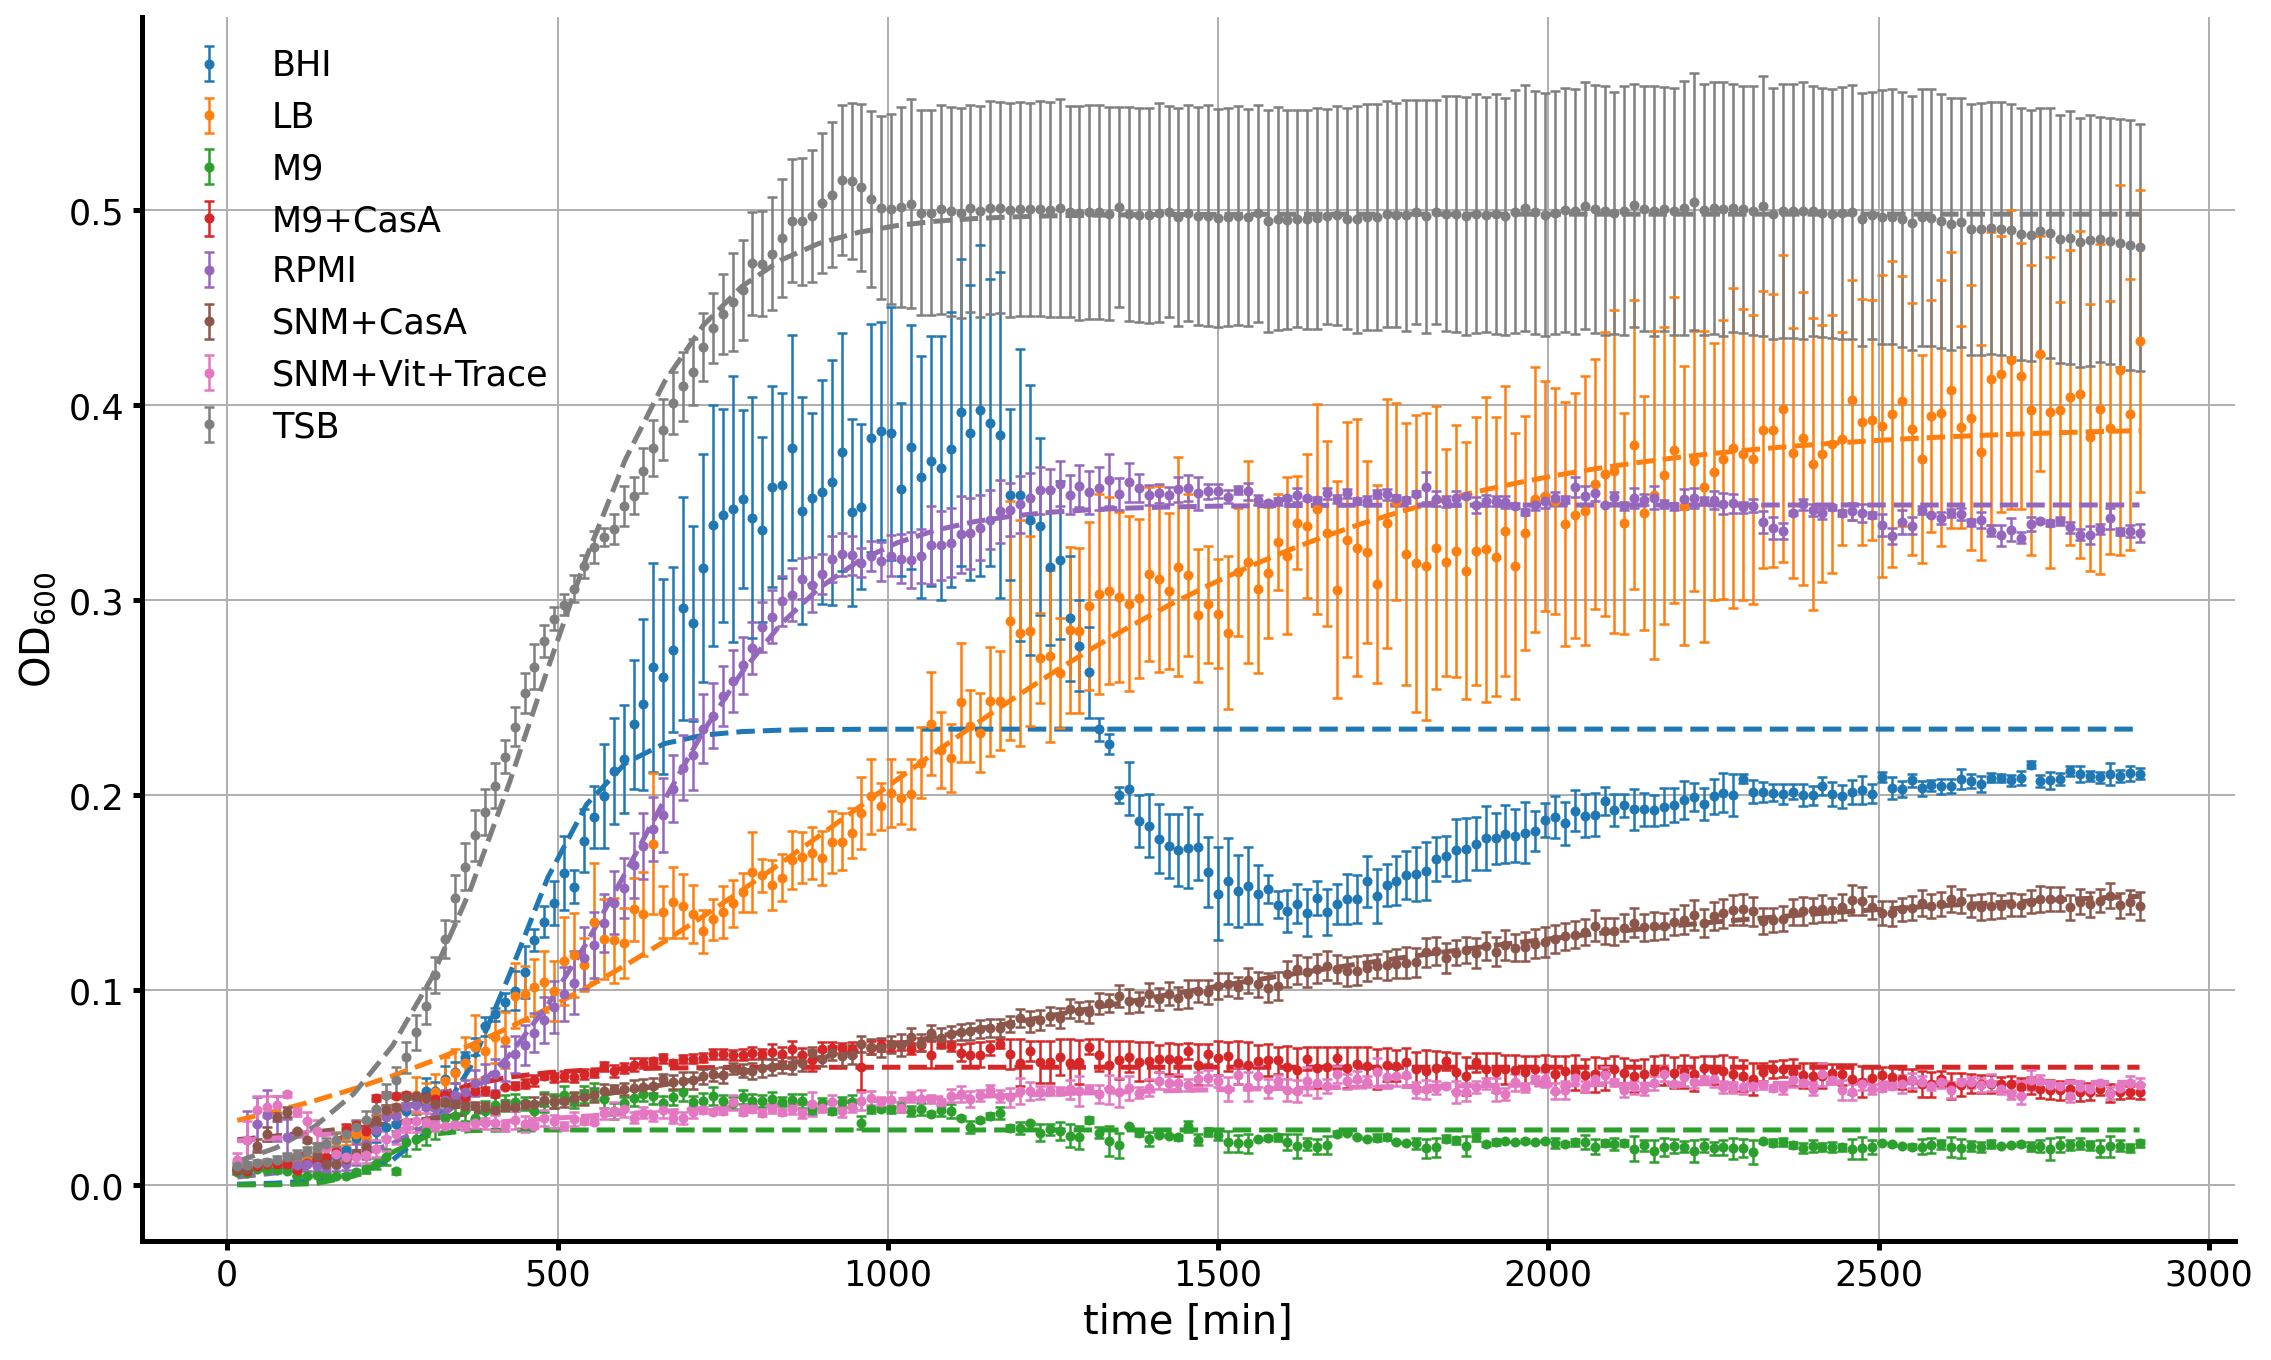

In [ ]:
plt.close('all')
fit_func = logistic_mod
fig = plt.figure(figsize=(15, 9))
for medium, values in errors.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        df_growth, fit_params = extract_growthrate(values[medium].assign(Time=pd.Series(errors['Time']['mean'])), fit_func)
        t = np.linspace(errors['Time']['mean'].min(), errors['Time']['mean'].max())
        lines = plt.plot(t,fit_func(t, *fit_params.loc['mean']), '--')
        plt.errorbar(x = errors['Time']['mean'],
                   y = values[medium]['mean'],
                   yerr = values[medium]['sem'],
                   capsize=2, 
                   elinewidth=1,
                   fmt='.',
                   label=medium,
                   markeredgewidth=1,
                   color = lines[0].get_color(), # use same color for fit as for data
                   )
        #plt.yscale('log', nonpositive='clip')
        plt.xlabel('time [min]')
        plt.ylabel('OD$_{600}$')
        plt.grid(True)
        plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

Now we only want to display LB medium and the fit.

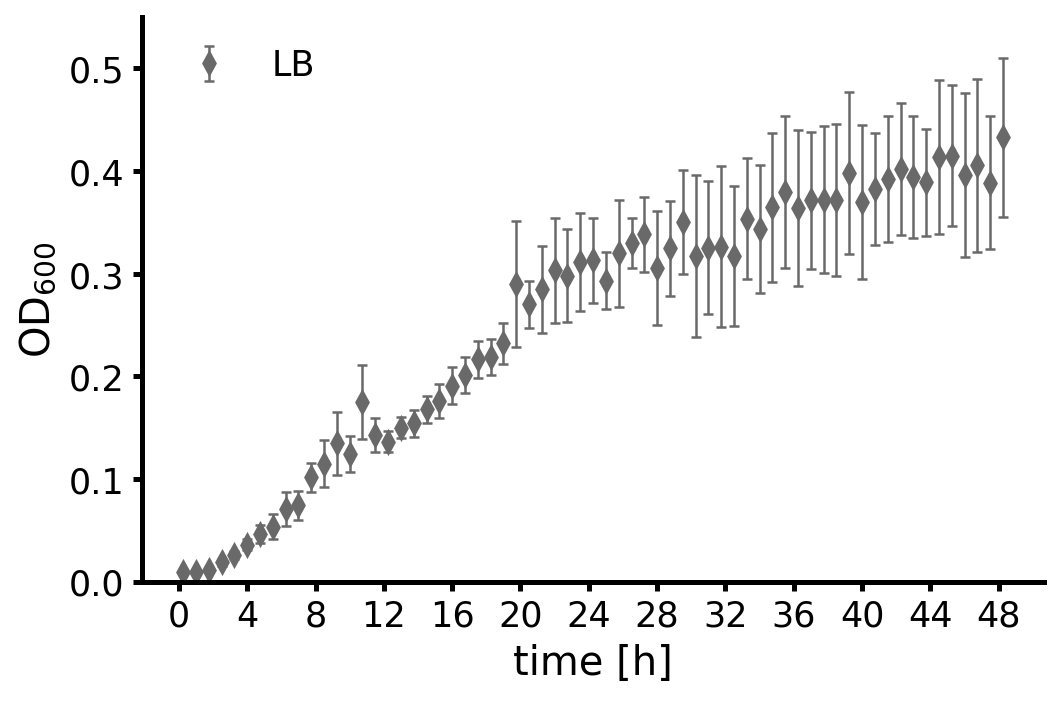

In [ ]:
plt.close('all')
i = 0
interest = errors[['LB']]
for medium, values in interest.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        plt.errorbar(x = errors['Time']['mean'][::3] / 60,
                y = values[medium]['mean'][::3],
                yerr = values[medium]['sem'][::3],
                fmt='.',
                label=medium,
                marker=markers[i],
                color = greys[i],
                ms=6,
                #linestyle='-',
                linewidth=1.0,
                )
        plt.xticks(np.arange(0, errors['Time']['mean'].max() / 60, 4))
        plt.xlabel('time [h]')
        plt.ylabel('OD$_{600}$')
        plt.ylim((0,0.55))
        plt.legend(loc='upper left', ncol=2)#fontsize=8,)# bbox_to_anchor=(-0.00, 1.15), loc='upper left', ncol=4)
        i +=1

plt.tight_layout()
interest['LB'].to_csv('media_avg/LB_'+ str(STRAIN) +'.csv')

Extract other meas of media.

In [ ]:
interest = errors[['BHI']]
interest['BHI'].to_csv('media_avg/BHI_'+ str(STRAIN) +'.csv')

### Extracting other LB averages since the direct data seems to be off (obsolete? fitting issue?)

In [ ]:
dates = [220531, 220517, 210831, 220609, 220614]
lb = pd.DataFrame()
for date in dates:
    excel_file = str(date) + '_Cstr.xlsx'
    nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
    df = pd.read_excel(path_to_excel+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
    growth, errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)
    lb[date] = growth['14']['LB']

In [ ]:
def double_std(array):
    return np.std(array) * 2
lb

,220531,220517,210831,220609,220614
0,0.002667,0.015000,0.014000,0.001667,0.005000
1,0.006000,0.017000,0.017667,0.001667,0.004778
2,0.008333,0.019000,0.022000,0.003333,0.004778
3,0.011000,0.022667,0.028000,0.004333,0.005111
4,0.014333,0.028000,0.035000,0.005000,0.005444
...,...,...,...,...,...
91,0.544333,0.848333,0.901333,0.408000,0.463889
92,0.546667,0.850667,0.902000,0.393667,0.448000
93,0.552000,0.851667,0.901667,0.406000,0.447889
94,0.545000,0.850333,0.901333,0.408333,0.450667


In [ ]:
lb['min'] = lb.mean(axis = 1) - lb.min(axis=1)
lb['max'] = lb.max(axis=1) - lb.mean(axis = 1)
lb['mean'] = lb[dates].mean(axis = 1)
lb['std'] = lb[dates].std(axis=1)
time = pd.read_csv('media_avg/time.csv', index_col=0)
time = time.iloc[0:96]
lb
popts, pcovs = curve_fit(logistic_mod, time['mean'][:40], lb['mean'][:40], np.asarray([0.5,0.5,0.002]))
dt = round((np.log(2)/popts[2]),2)
dt

58.72

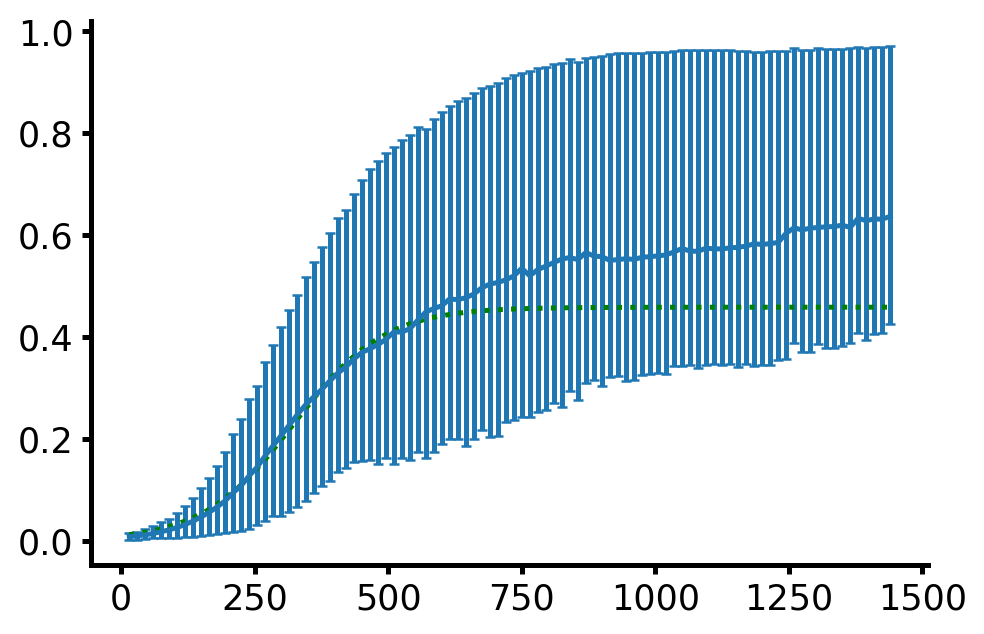

In [ ]:
plt.errorbar(time['mean'], lb['mean'], yerr=lb[['min', 'max']].T.values)
t = np.linspace(time['mean'].min(), time['mean'].max())
#plt.errorbar(time['mean'], lb['mean'], yerr=lb['std'])
plt.plot(t, logistic_mod(t, *popts),
                color=colorstandards[str(strain)], 
                linestyle=':',
                linewidth=2.0, )